### Task 6

Mount the drive in our code for extracting thr data set

In [5]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


EEG Signal Classification Using Fourier and ZCR Features with SVM (labels 0 1 2 3 represents four classes respectively) this code also gives evaluation matrix


Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.79      0.79       530
           1       0.85      0.71      0.78       136
           2       0.79      0.83      0.81       693
           3       0.90      0.76      0.82        21

    accuracy                           0.81      1403
   macro avg       0.83      0.77      0.80      1403
weighted avg       0.81      0.81      0.81      1403





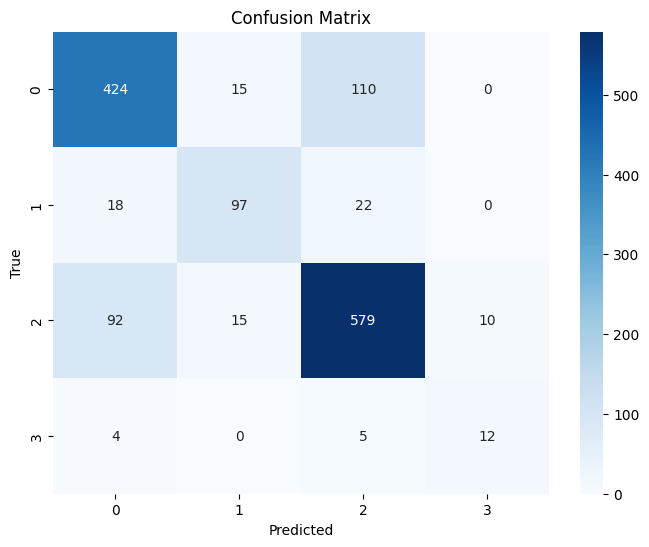

In [6]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, balanced_accuracy_score, roc_auc_score

# Function to load data and assign labels
def load_data(data_path, sample_size=None):
    features = []
    labels = []
    for label_folder in sorted(os.listdir(data_path)):
        folder_path = os.path.join(data_path, label_folder)
        if os.path.isdir(folder_path):
            if label_folder == "Complex_Partial_Seizures":
                label = 0
            elif label_folder == "Electrographic_Seizures":
                label = 1
            elif label_folder == "Normal":
                label = 2
            elif label_folder == "Video_detected_Seizures_with_no_visual_change_over_EEG":
                label = 3  # Folder name is the label
            else:
                continue  # Skip unknown folders

            for file in os.listdir(folder_path):
                if file.endswith('.npy'):
                    file_path = os.path.join(folder_path, file)
                    sample = np.load(file_path)  # Load the npy file
                    features.append(extract_features_from_sample(sample))
                    labels.append(label)
                    if sample_size and len(features) >= sample_size:
                        return np.array(features), np.array(labels)
    return np.array(features), np.array(labels)

# Function to extract fewer Fourier features and ZCR features from a single sample
def extract_features_from_sample(sample):
    num_channels, num_points = sample.shape
    # Use only a smaller portion of Fourier features (e.g., first 10 frequencies)
    fourier_features = []
    for channel in range(num_channels):
        fft_values = np.fft.fft(sample[channel])
        fourier_features.extend(np.abs(fft_values[:10]))  # Only first 10 frequencies
    # ZCR features (unchanged)
    zcr_features = []
    for channel in range(num_channels):
        zcr = ((sample[channel][:-1] * sample[channel][1:]) < 0).sum() / len(sample[channel])
        zcr_features.append(zcr)
    return fourier_features + zcr_features

# Load a smaller sample of training and validation data (e.g., 500 samples)
train_data_path = 'drive/MyDrive/EEG_Data/train_data'
val_data_path = 'drive/MyDrive/EEG_Data/validation_data'
X_train, y_train = load_data(train_data_path, sample_size=500)
X_val, y_val = load_data(val_data_path, sample_size=500)

# Check the class distribution in the training data
print("Class distribution in y_train:", pd.Series(y_train).value_counts())

# If classes are missing or there is only one class, raise an error or fix the dataset
if len(np.unique(y_train)) < 2:
    raise ValueError("The training data contains less than two classes. Please check your dataset.")

# Load test data
def load_test_data(test_path):
    test_features = []
    test_filenames = []
    for file in os.listdir(test_path):
        if file.endswith('.npy'):
            file_path = os.path.join(test_path, file)
            sample = np.load(file_path)
            test_features.append(extract_features_from_sample(sample))
            test_filenames.append(file)
    return np.array(test_features), test_filenames

X_test, test_filenames = load_test_data('drive/MyDrive/EEG_Data/test_data')

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Train an SVM model with a smaller complexity (e.g., lower C, different kernel)
svm_model = SVC(kernel='rbf', C=0.1, gamma=0.1, random_state=42, probability=True)
svm_model.fit(X_train, y_train)

# Validate the model
y_val_pred = svm_model.predict(X_val)
y_val_proba = svm_model.predict_proba(X_val)

# Evaluation metrics
print("Classification Report:")
print(classification_report(y_val, y_val_pred, zero_division=1))
roc_auc = roc_auc_score(y_val, y_val_proba, multi_class='ovr', average='macro')
balanced_acc = balanced_accuracy_score(y_val, y_val_pred)
print(f"ROC AUC Score: {roc_auc}")
print(f"Balanced Accuracy Score: {balanced_acc}")
